# NHANES Analysis
## Body Mass Index (BMI) Among Adults (21+ Years)

This analysis seeks to determine if BMI has significantly increased in the past decade and a half. 

Body Mass Index (BMI) is a person’s weight in kilograms divided by the square of height in meters. As a ratio of weight to height, it may be a more reliable indicator than weight alone of body fatness and, indirectly, of health problems that have at times been associated with excess weight. 

As a potential health indicator, it may be informative to understand recent trends of BMI and specifically whether that measure has significantly increased. There are regular articles in the news with scary headlines about Americans' increasing weight and implications about what that means for public health and the healthcare system. But what increases do the data actually show?

Analysis will be restricted to adults due to recommendations by the CDC to interpret BMI for children and teens separately from adults.

Methodology Summary:

To compare two times periods for a difference, data from the 2-year cycle 1999-2000 and from the 2-year cycle 2015-2016 were selected (the latter cycle being the most recent complete data available).

The variable of interest selected was **BMXBMI** (Body Mass Index (kg/m\*\*2) for males and females 2 YEARS - 150 YEARS).

For filtering the data for only adults, the variable **RIDAGEEX** (age in months at time of examination) was selected, since the examination data set is the one that contains the variable of interest.

Sources and Background:

General BMI Info:
https://www.cdc.gov/healthyweight/assessing/bmi/)

BMI in Children and Teens vs. Adults:
https://www.cdc.gov/healthyweight/assessing/bmi/childrens_bmi/about_childrens_bmi.html. 
(In particular, see the section "Is BMI interpreted the same way for children and teens as it is for adults?", URL https://www.cdc.gov/healthyweight/assessing/bmi/childrens_bmi/about_childrens_bmi.html#interpreted.)

Age Cutoff of 21 Years: 
"Teen" in "children and teens" was not defined directly in the reference materials above. However, growth charts for children and teens are provided here https://www.cdc.gov/growthcharts/clinical_charts.htm for ages up to and including 20 years of age; this supports definition of "teens" as 20 and below.

In [1]:
import importlib
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

In [2]:
# Import demographic data (e.g., age, gender)
# for each participant
filename = "1999-2000/DEMO.XPT"
demo_2000 = pd.read_sas(filename)
demo_2000.shape

(9965, 144)

In [6]:
# Participant identified in SEQN column
# Confirm dataset has only one entry per participant
# Necessary for later combining demographic data and body measures data into one df
demo_2000["SEQN"].is_unique

True

In [7]:
# Import body measurement data
filename = "1999-2000/BMX.XPT"
bmx_2000 = pd.read_sas(filename)
bmx_2000.shape

(9282, 38)

In [8]:
# Participant identified in SEQN column
# Confirm dataset has only one entry per participant
bmx_2000["SEQN"].is_unique

True

In [9]:
# Add bmx info to demo info
combined_2000 = demo_2000.merge(bmx_2000, how="left", on="SEQN")
combined_2000.shape

(9965, 181)

In [19]:
# Verify new column count meets expectations
# Should be number of cols in each dataframe minus 1 for shared col (SEQN)
(demo_2000.shape[1] + bmx_2000.shape[1] - 1) == (144 + 38 - 1)

True

In [11]:
# Repeat steps with data from survey year 2015-2016

In [12]:
filename = "2015-2016/DEMO_I.XPT"
demo_2016 = pd.read_sas(filename)
demo_2016.shape

(9971, 47)

In [13]:
demo_2016["SEQN"].is_unique

True

In [14]:
filename = "2015-2016/BMX_I.XPT"
bmx_2016 = pd.read_sas(filename)
bmx_2016.shape

(9544, 26)

In [15]:
bmx_2016["SEQN"].is_unique

True

In [16]:
combined_2016 = demo_2016.merge(bmx_2016, how="left", on="SEQN")
combined_2016.shape

(9971, 72)

In [17]:
(demo_2016.shape[1] + bmx_2016.shape[1] - 1) == (47 + 26 - 1)

True

In [22]:
# Combine 2000 and 2016 data sets

In [23]:
# Add column to each data set so we can later
# identify the year
new_col = "Survey Year"
combined_2000[new_col] = "1999-2000"
combined_2016[new_col] = "2015-2016"

In [24]:
# Combine 2000 and 2016 dfs

# Note: In Pandas 0.23, must explicitly pass a sorting 
# argument in order to avoid a warning (default = None)
# Pass True to sort columns by name
data = pd.concat([combined_2000, combined_2016], sort=True)

# Print shapes and counts of new combined df
print("Shape of combined data: {}".format(data.shape))
print("\n")
print("Count of obs by survey year: {}".format(data.groupby("Survey Year").size()))

Shape of combined data: (19936, 212)


Count of obs by survey year: Survey Year
1999-2000    9965
2015-2016    9971
dtype: int64


In [109]:
# Examine proposed column for age 

df = data
age_months_column = "RIDAGEEX"
survey_year_column = "Survey Year"

df.groupby(survey_year_column).count()[age_months_column]

Survey Year
1999-2000    9141
2015-2016       0
Name: RIDAGEEX, dtype: int64

In [25]:
# An examination of the codebook for survey year 2015-2016 shows that months variable is 
# now only used for subjects 24 months and under
# A new variable, RIDAGEYR, is available and represents age in years at time of screening

# This will need to be taken into account when converting months to years for 1999-2000 data

In [26]:
def assign_age_in_years(row):
    
    """
    Function to assign age in years. Different
    approaches are necessary for different survey years.
    Age was listed in months for all subjects for earlier data,
    but then an age in years variable was added.
    """
    from numpy import nan
    
    age_years_col = "RIDAGEYR"
    age_months_col = "RIDAGEEX"
    
    try:
        age_years = row[age_years_col]
    except KeyError:
        
        try:
            age_years = int(row[age_months_col] / 12)
        except KeyError:
            age_years = nan
        # if value is nan will return value error when trying to
        # convert to int
        except ValueError:
            age_years = row[age_months_col]
            
    return age_years

In [27]:
# Add a column that converts age in months to age in years
df = data
new_age_years_column = "RIDAGEEX_years"

df[new_age_years_column] = df.apply(assign_age_in_years, axis=1)

In [28]:
# Examine new proposed column for age 

df = data
age_column = new_age_years_column
survey_year_column = "Survey Year"

df.groupby(survey_year_column).count()[age_column]

Survey Year
1999-2000    9965
2015-2016    9971
Name: RIDAGEEX_years, dtype: int64

In [29]:
# Examine count of groups of 21+ and under 21

count_per_age_group = df.groupby(age_column).size()

all_age_count = count_per_age_group.sum()
index_under_21_filter = lambda x: x.index < 21
under_21_count = count_per_age_group[index_under_21_filter(count_per_age_group)].sum()
over_21_count = count_per_age_group[~index_under_21_filter(count_per_age_group)].sum()
age_count_test = all_age_count == (under_21_count + over_21_count)
print("""
Count of all observations with ages: {}
Count of observations for those under 21: {}
Count of observations for those 21+: {}

Test: Count of obs < 21 + count of obs >= 21 match count of all obs: {}""".format(
    all_age_count, 
    under_21_count, 
    over_21_count, 
    age_count_test))



Count of all observations with ages: 19936
Count of observations for those under 21: 9505
Count of observations for those 21+: 10431

Test: Count of obs < 21 + count of obs >= 21 match count of all obs: True


In [30]:
# Filter for age 21+ and confirm shape of df after filter

df = data
age_years_threshold = 21
age_filter = (df[age_column] >= age_years_threshold)

data_adults = df[age_filter].copy()
data_adults.shape

(10431, 213)

In [31]:
# Examine filtered data counts by survey year

df = data_adults

df.groupby("Survey Year").size()

Survey Year
1999-2000    4795
2015-2016    5636
dtype: int64

### The CDC publishes separate BMI guidelines for men and women, so the analysis will  review these groups separately.

In [32]:
# Create mapping of gender code to more readable value
# Per codebook 1.0 = male and 2.0 = female
gender_map = {1.0: "Male",
             2.0: "Female",
             np.nan: "Missing"}

In [33]:
# Add column with gender code translation
df = data_adults

col = "RIAGENDR"
new_col = col + "_x"
df[new_col] = df[col].map(gender_map)

In [34]:
print("Participant Counts by Gender")
df.groupby([new_col, "Survey Year"]).size()
#df[new_col].value_counts(dropna=False)

Participant Counts by Gender


RIAGENDR_x  Survey Year
Female      1999-2000      2565
            2015-2016      2932
Male        1999-2000      2230
            2015-2016      2704
dtype: int64

### Create viz's and compute summary stats of bmi measurements

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


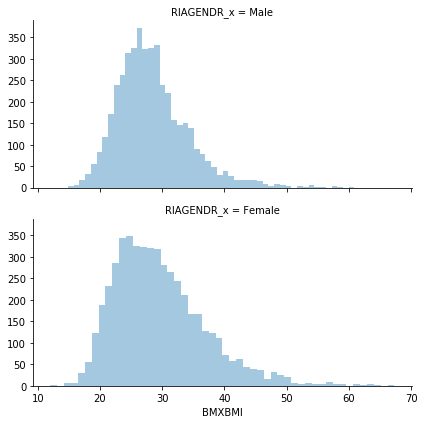

In [35]:
df = data_adults
cat_col = new_col
data_col = "BMXBMI"

g = sns.FacetGrid(df, row=cat_col, aspect=2)
g = g.map(sns.distplot, data_col, kde=False)

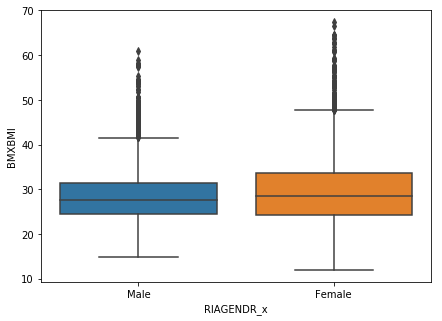

In [36]:
plt.figure(figsize=(7, 5))
sns.boxplot(x=cat_col, y=data_col, data=df)

In [38]:
# Compute summary stats
# Note: Wrapped in df call for display purposes only

print("BMI Summary Stats - All Genders")
pd.DataFrame(df[data_col].describe())

BMI Summary Stats - All Genders


,BMXBMI
count,9620.000000
mean,29.055832
std,6.731272
min,12.040000
25%,24.340000
50%,28.000000
75%,32.500000
max,67.300000


In [39]:
# Segment summary by gender

print("BMI Summary Stats - Male and Female Participants")
df.groupby(cat_col).describe()[data_col].T

BMI Summary Stats - Male and Female Participants


RIAGENDR_x,Female,Male
count,5071.000000,4549.000000
mean,29.614772,28.432752
std,7.411832,5.818364
min,12.040000,14.860000
25%,24.195000,24.500000
50%,28.500000,27.600000
75%,33.600000,31.300000
max,67.300000,60.870000


### Explore BMI's between 2000 and 2016 surveys

In [40]:
# Create df's for each gender response

In [41]:
df = data_adults
male_filter = (df["RIAGENDR" + "_x"] == "Male")
female_filter = (df["RIAGENDR" + "_x"] == "Female")

data_male = df[male_filter]
data_female = df[female_filter]

In [42]:
# Gender response = Male

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


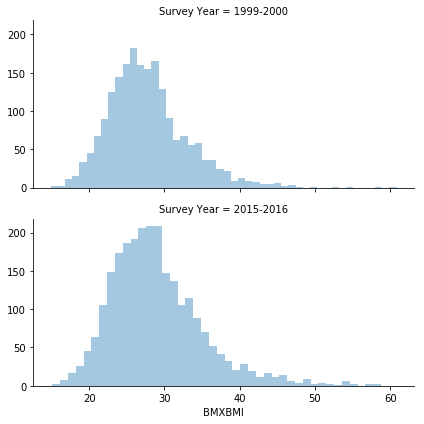

In [43]:
df = data_male
cat_col = "Survey Year"
data_col = "BMXBMI"

g = sns.FacetGrid(df, row=cat_col, aspect=2)
g = g.map(sns.distplot, data_col, kde=False)

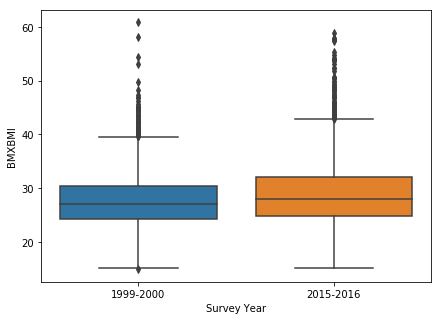

In [44]:
plt.figure(figsize=(7, 5))
sns.boxplot(x=cat_col, y=data_col, data=df)

In [45]:
# Summary stats segmented by survey year

print("BMI Summary Stats - Male")
df.groupby(cat_col).describe()[data_col].T

BMI Summary Stats - Male


Survey Year,1999-2000,2015-2016
count,2006.000000,2543.000000
mean,27.772727,28.953401
std,5.284003,6.158823
min,14.860000,15.100000
25%,24.272500,24.750000
50%,27.090000,28.000000
75%,30.380000,32.000000
max,60.870000,58.800000


In [46]:
# Gender response = Female

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


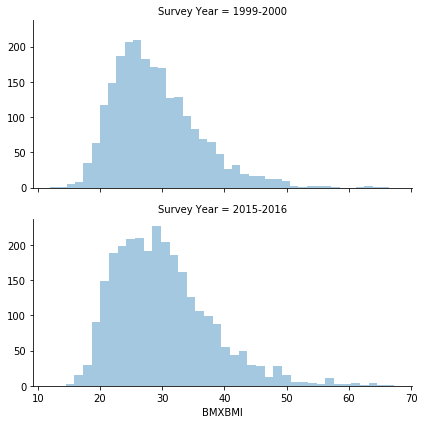

In [47]:
df = data_female
cat_col = "Survey Year"
data_col = "BMXBMI"

#sns.set()
#sns.set_context("talk")
g = sns.FacetGrid(df, row=cat_col, aspect=2)
g = g.map(sns.distplot, data_col, kde=False)

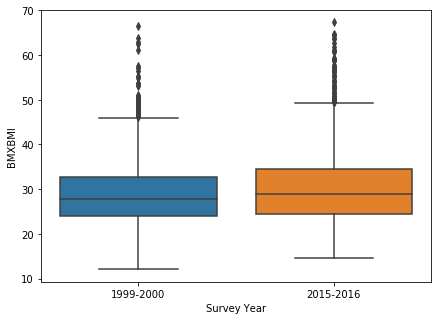

In [48]:
plt.figure(figsize=(7, 5))
sns.boxplot(x=cat_col, y=data_col, data=df)

In [49]:
# Summary stats segmented by survey year

print("BMI Summary Stats - Female")
df.groupby(cat_col).describe()[data_col].T

BMI Summary Stats - Female


Survey Year,1999-2000,2015-2016
count,2287.000000,2784.000000
mean,28.973769,30.141343
std,6.927155,7.749105
min,12.040000,14.500000
25%,24.010000,24.400000
50%,27.820000,29.000000
75%,32.780000,34.400000
max,66.440000,67.300000


In [50]:
# Examine year and gender segments together

df = data_adults
data_segmented_summary_stats = df.groupby(["RIAGENDR" + "_x", "Survey Year"]).describe()[data_col].T
data_segmented_summary_stats

RIAGENDR_x        Female                      Male             
Survey Year    1999-2000    2015-2016    1999-2000    2015-2016
count        2287.000000  2784.000000  2006.000000  2543.000000
mean           28.973769    30.141343    27.772727    28.953401
std             6.927155     7.749105     5.284003     6.158823
min            12.040000    14.500000    14.860000    15.100000
25%            24.010000    24.400000    24.272500    24.750000
50%            27.820000    29.000000    27.090000    28.000000
75%            32.780000    34.400000    30.380000    32.000000
max            66.440000    67.300000    60.870000    58.800000

In [51]:
# Obtain differences between each survey year for each gender

In [52]:
calc_label = "Diff, Y2000 to Y2016"

gen = "Female"

data_segmented_summary_stats.loc[:, (gen, calc_label)] = \
    data_segmented_summary_stats.loc[:, gen].iloc[:, 1] \
    - data_segmented_summary_stats.loc[:, gen].iloc[:, 0]

gen = "Male"

data_segmented_summary_stats.loc[:, (gen, calc_label)] = \
    data_segmented_summary_stats.loc[:, gen].iloc[:, 1] \
    - data_segmented_summary_stats.loc[:, gen].iloc[:, 0]

In [53]:
data_segmented_summary_stats

RIAGENDR_x        Female                      Male               \
Survey Year    1999-2000    2015-2016    1999-2000    2015-2016   
count        2287.000000  2784.000000  2006.000000  2543.000000   
mean           28.973769    30.141343    27.772727    28.953401   
std             6.927155     7.749105     5.284003     6.158823   
min            12.040000    14.500000    14.860000    15.100000   
25%            24.010000    24.400000    24.272500    24.750000   
50%            27.820000    29.000000    27.090000    28.000000   
75%            32.780000    34.400000    30.380000    32.000000   
max            66.440000    67.300000    60.870000    58.800000   

RIAGENDR_x                Female                 Male  
Survey Year Diff, Y2000 to Y2016 Diff, Y2000 to Y2016  
count                 497.000000           537.000000  
mean                    1.167574             1.180675  
std                     0.821950             0.874820  
min                     2.460000             0.240000  
25%                     0.390000             0.477500  
50%                     1.180000             0.910000  
75%                     1.620000             1.620000  
max                     0.860000            -2.070000

### Determine if the differences between the two years is significant

In [57]:
# Start with gender response = Female

# NULL Hypothesis: The BMI of female respondents has not significantly 
#                  increased between the Y2000 and Y2016 surveys

# Alternate Hypothesis: The BMI of female respondents has significantly 
#                   increased between the Y2000 and Y2016 surveys

In [58]:
# Create helper functions

In [59]:
def create_df_filter(df, col, filter_value):
    
    return (df[col] == filter_value)

In [60]:
def df_get_values(df, data_col, dropna=True):
    
    if dropna is True:
        df = df.dropna(axis=0, subset=[data_col], how='all')
    
    return list(df[data_col].values)

### Store values for each survey year and gender

In [61]:
# Get BMI values for each survey year and gender

df = data_adults
data_col = "BMXBMI"
cat_col = "RIAGENDR" + "_x"
year_col = "Survey Year"

# Create gender filters
female_filter = create_df_filter(df, cat_col, "Female")
male_filter = create_df_filter(df, cat_col, "Male")

# Create survey year filters
survey_year_list = ["1999-2000", "2015-2016"]
year_filter_dict = {
                    survey_year: create_df_filter(
                                df, year_col, survey_year
                                ) for survey_year in survey_year_list}



# Filter overall df and then store values for each gender and survey year

# Create dictionary to store data sets
data_sets_dict = {}

female_2000_df = df[female_filter & year_filter_dict.get("1999-2000")]
female_2000_bmi = df_get_values(female_2000_df, data_col)
data_sets_dict["Female_1999-2000"] = female_2000_bmi

female_2016_df = df[female_filter & year_filter_dict.get("2015-2016")]
female_2016_bmi = df_get_values(female_2016_df, data_col)
data_sets_dict["Female_2015-2016"] = female_2016_bmi

male_2000_df = df[male_filter & year_filter_dict.get("1999-2000")]
male_2000_bmi = df_get_values(male_2000_df, data_col)
data_sets_dict["Male_1999-2000"] = male_2000_bmi

male_2016_df = df[male_filter & year_filter_dict.get("2015-2016")]
male_2016_bmi = df_get_values(male_2016_df, data_col)
data_sets_dict["Male_2015-2016"] = male_2016_bmi

In [62]:
# Store data in variables to be able to run tests

# Note: For these tests making later year first set so difference
# between means is poz if mean is greater

a = data_sets_dict["Female_2015-2016"]
b = data_sets_dict["Female_1999-2000"]

c = data_sets_dict["Male_2015-2016"]
d = data_sets_dict["Male_1999-2000"]

### To compare means for 2016 and 2000 for each gender, we can run a t-test for two independent samples.

### However, we need to test the following assumptions:
* independence of observations
* equal variances (to determine if need to run with Welch's t-test adjustment for standard error)
* normality of each data set

Independence: There is no indication in the NHANES description that respondents are re-sampled across survey years, so independence is assumed.

Variance and Normality: see below

### Run Levene's test on data to test for equal variances

H0 = The variances are equal

H1 = The variances are not equal

alpha = .05

In [63]:
print("Leven's test for equal variances - Female (Y2016 and 2000)")
stat, p = stats.levene(a, b)
print("Test statistic: {} (p-value: {})".format(stat, p))
print("\n")

print("Leven's test for equal variances - Male (Y2016 and 2000)")
stat, p = stats.levene(c, d)
print("Test statistic: {} (p-value: {})".format(stat, p))

Leven's test for equal variances - Female (Y2016 and 2000)
Test statistic: 21.519380344267116 (p-value: 3.5908661123980997e-06)


Leven's test for equal variances - Male (Y2016 and 2000)
Test statistic: 25.959833500407584 (p-value: 3.6271893783017997e-07)


### Conclusion: Reject null that variances are equal; run Welch's t-test for t-test with unequal variances

In [158]:
# Due to unequal sample sizes and unequal standard deviations
# will perform a Welch's t-test instead of a standard t-test
# This can be accomplished in scipy.stats by flagging
# equal_var = False

### Test normality assumption: perform a Shapiro-Wilk test to test how close to normal dist sample data are

#### At alpha = .05, if P < .05 then reject null hypothesis that data come from a normal dist

In [66]:
for desc, data_set in data_sets_dict.items():
    print("Shapiro-Wilk normality test results: {}".format(desc))
    shapiro_wilk = stats.shapiro(data_set)
    print("Test-stat: {} (p-value: {})".format(shapiro_wilk[0], shapiro_wilk[1]))
    print("\n")

Shapiro-Wilk normality test results: Female_1999-2000
Test-stat: 0.9453644752502441 (p-value: 2.5522888253618733e-28)


Shapiro-Wilk normality test results: Female_2015-2016
Test-stat: 0.9445222616195679 (p-value: 3.764761164652554e-31)


Shapiro-Wilk normality test results: Male_1999-2000
Test-stat: 0.9545952081680298 (p-value: 1.6910393128943063e-24)


Shapiro-Wilk normality test results: Male_2015-2016
Test-stat: 0.939537763595581 (p-value: 5.096896955589146e-31)




### Conclusion: Shapiro-Wilk tests strongly suggests data is not from a normal distribution.
### Review QQ plot as further confirmation

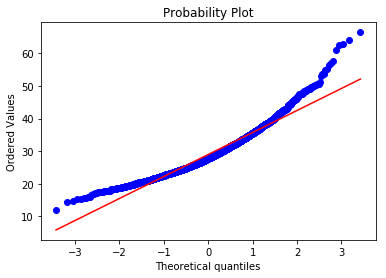

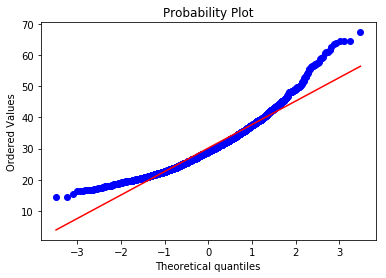

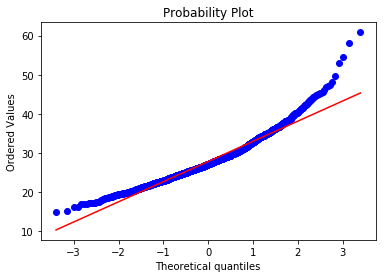

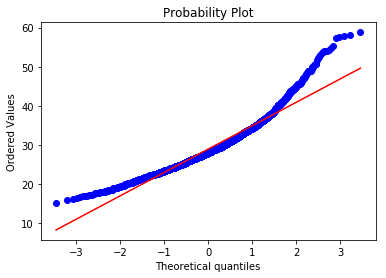

In [67]:
for desc, data_set in data_sets_dict.items():
    stats.probplot(data_set, plot=sns.mpl.pyplot)
    plt.show()

In [161]:
# Run test of skew and kurtosis to estimate probability that
# samples come from normal distribution

# Each test statistic should be around 1 for a normal distribution

for desc, data_set in data_sets_dict.items():
    skew = stats.skewtest(data_set)
    kurtosis = stats.kurtosistest(data_set)
    print("{}".format(desc))
    print("Skew Normal: test-statistic {} (p-value: {})".format(skew[0], skew[1]))
    print("Kurtosis Normal: test-statistic {} (p-value: {})".format(kurtosis[0], kurtosis[1]))
    print("\n")


Female_1999-2000
Skew Normal: test-statistic 17.051680083191854 (p-value: 3.3962909573197247e-65)
Kurtosis Normal: test-statistic 9.764083687369043 (p-value: 1.6055679646924846e-22)


Female_2015-2016
Skew Normal: test-statistic 18.536143176266442 (p-value: 1.0552331097665981e-76)
Kurtosis Normal: test-statistic 9.889058469297 (p-value: 4.643747144307868e-23)


Male_1999-2000
Skew Normal: test-statistic 15.499915094430433 (p-value: 3.473508675127845e-54)
Kurtosis Normal: test-statistic 10.658705064344273 (p-value: 1.5879293694771922e-26)


Male_2015-2016
Skew Normal: test-statistic 19.043767376400645 (p-value: 7.400775185177088e-81)
Kurtosis Normal: test-statistic 11.595344957347983 (p-value: 4.351089812995122e-31)




In [162]:
# Transform data and review to see if that improves normality

In [163]:
print("Tests of normality on log-transformed data\n")
for desc, data_set in data_sets_dict.items():
    # transform data set
    data_set = np.log(data_set)
    
    shapiro_wilk = stats.shapiro(data_set)
  
    print("{}".format(desc))
    print("Shapiro-Wilk Normal: test-statistic {} (p-value: {})".format(shapiro_wilk[0], shapiro_wilk[1]))
    print("Skew Normal: test-statistic {} (p-value: {})".format(skew[0], skew[1]))
    print("Kurtosis Normal: test-statistic {} (p-value: {})".format(kurtosis[0], kurtosis[1]))
    print("\n")


Tests of normality on log-transformed data

Female_1999-2000
Shapiro-Wilk Normal: test-statistic 0.9937524199485779 (p-value: 2.8039080390840354e-08)
Skew Normal: test-statistic 5.860107480782281 (p-value: 4.625676788621316e-09)
Kurtosis Normal: test-statistic 0.9473003057710355 (p-value: 0.3434857750768877)


Female_2015-2016
Shapiro-Wilk Normal: test-statistic 0.9933714866638184 (p-value: 6.017266684921196e-10)
Skew Normal: test-statistic 6.113239290454367 (p-value: 9.762880858603675e-10)
Kurtosis Normal: test-statistic -1.159426862619222 (p-value: 0.24628223242138625)


Male_1999-2000
Shapiro-Wilk Normal: test-statistic 0.9944562315940857 (p-value: 8.012418106773112e-07)
Skew Normal: test-statistic 4.9446161999252105 (p-value: 7.629402311035486e-07)
Kurtosis Normal: test-statistic 3.708570502181642 (p-value: 0.0002084326287671954)


Male_2015-2016
Shapiro-Wilk Normal: test-statistic 0.9907311201095581 (p-value: 9.70051556442586e-12)
Skew Normal: test-statistic 7.583245087260999 (p-v

In [164]:
# The log transform normalizes the skew of the male data
# but does not affect other measures or the female data

Female_1999-2000


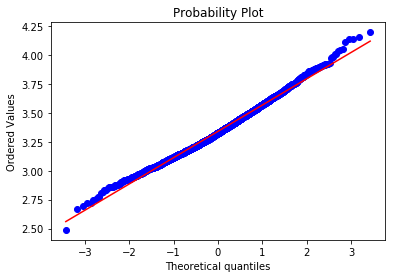

Female_2015-2016


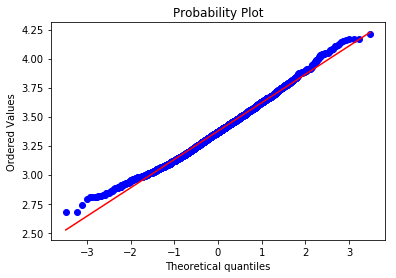

Male_1999-2000


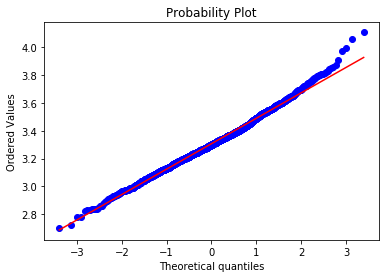

Male_2015-2016


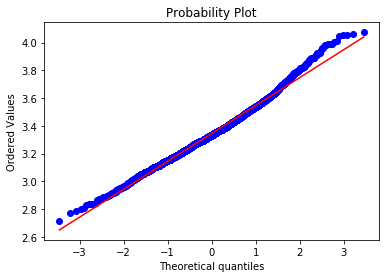

In [165]:
# Review QQ plot as further confirmation

for desc, data_set in data_sets_dict.items():
    data_set = np.log(data_set)
    print(desc)
    stats.probplot(data_set, plot=sns.mpl.pyplot)
    plt.show()

In [166]:
# Try taking square root of data, which also can help right-skewed distributions

In [167]:
print("Tests of normality on data transformed by taking the square root\n")
for desc, data_set in data_sets_dict.items():
    # transform data set
    data_set = np.sqrt(data_set)
    
    shapiro_wilk = stats.shapiro(data_set)
    skew = stats.skewtest(data_set)
    kurtosis = stats.kurtosistest(data_set)

    print("{}".format(desc))
    print("Shapiro-Wilk Normal: test-statistic {} (p-value: {})".format(shapiro_wilk[0], shapiro_wilk[1]))
    print("Skew Normal: test-statistic {} (p-value: {})".format(skew[0], skew[1]))
    print("Kurtosis Normal: test-statistic {} (p-value: {})".format(kurtosis[0], kurtosis[1]))
    print("\n")

Tests of normality on data transformed by taking the square root

Female_1999-2000
Shapiro-Wilk Normal: test-statistic 0.9759547710418701 (p-value: 3.4681723700272465e-19)
Skew Normal: test-statistic 11.79164964196254 (p-value: 4.3101481924808793e-32)
Kurtosis Normal: test-statistic 4.899875498895337 (p-value: 9.589740450762743e-07)


Female_2015-2016
Shapiro-Wilk Normal: test-statistic 0.9757089018821716 (p-value: 2.200513282995944e-21)
Skew Normal: test-statistic 12.64636556116841 (p-value: 1.1717089397471497e-36)
Kurtosis Normal: test-statistic 4.196364396605596 (p-value: 2.712337319351698e-05)


Male_1999-2000
Shapiro-Wilk Normal: test-statistic 0.9800542593002319 (p-value: 3.965387918944559e-16)
Skew Normal: test-statistic 10.48195627032465 (p-value: 1.045582163098062e-25)
Kurtosis Normal: test-statistic 6.749782269951422 (p-value: 1.48067182890817e-11)


Male_2015-2016
Shapiro-Wilk Normal: test-statistic 0.9711254239082336 (p-value: 3.1060495686201767e-22)
Skew Normal: test-stati

In [168]:
# The square root transform somewhat normalizes the kurtosis of each gender
# in each year, but does not affect the other measures

Female_1999-2000


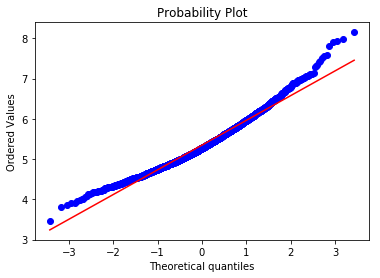

Female_2015-2016


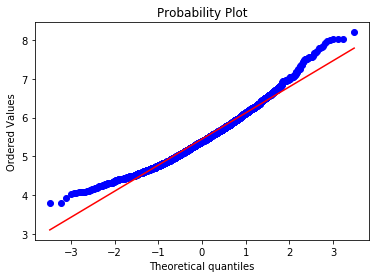

Male_1999-2000


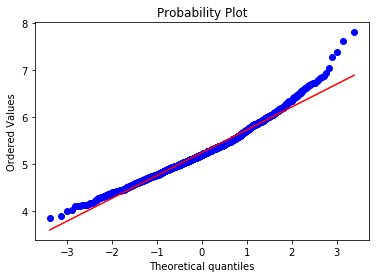

Male_2015-2016


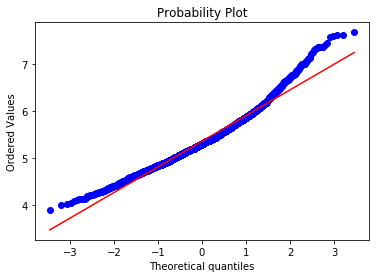

In [169]:
# Review QQ plot as further confirmation

for desc, data_set in data_sets_dict.items():
    data_set = np.sqrt(data_set)
    print(desc)
    stats.probplot(data_set, plot=sns.mpl.pyplot)
    plt.show()

In [170]:
# Both the measures and the plots indicate transformations do
# not normalize the data. The plots in particular show a lack of normality
# in the lower transformed values

In [171]:
# However, the t-test can still be run on skewed data if the sample size is large
# Examine sample sizes

for desc, data_set in data_sets_dict.items():
    print("{} sample size: {}".format(desc, len(data_set)))

Female_1999-2000 sample size: 2287
Female_2015-2016 sample size: 2784
Male_1999-2000 sample size: 2006
Male_2015-2016 sample size: 2543


In [172]:
# Sample size is quite large, and seems to support moving forward 
# with running t-test

In [173]:
# Run t-test and store results for each gender

t_test_ind_female = stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")
t_test_ind_male = stats.ttest_ind(c, d, equal_var=False, nan_policy="omit")

In [174]:
print("Female BMI Y2016 vs Y2000\nT-Statistic: {}\nP-Value: {}".format(
t_test_ind_female[0], t_test_ind_female[1]))

Female BMI Y2016 vs Y2000
T-Statistic: 5.660169797649858
P-Value: 1.5959822020285157e-08


In [175]:
print("Male BMI Y2016 vs Y2000\nT-Statistic: {}\nP-Value: {}".format(
t_test_ind_male[0], t_test_ind_male[1]))

Male BMI Y2016 vs Y2000
T-Statistic: 6.953031685030744
P-Value: 4.086910669466987e-12


In [176]:
# Results:
# * For both female and male respondents,
#   the difference in mean BMI appears to be significant
#   between the Y2000 and Y2016 surveys. This implies
#   BMI's among the general population has (statistically) significantly 
#   increased in this interval.
# * However, the sample size is large. While the size allows a parametric test like the
#   t-test to be run, its size is also large enough to detect even very small changes
#   in the BMI and suggest they are significant.